In [4]:
import numpy as np
from lstm_crf_tagger_conll2000 import LSTM_CRF_Tagger_CoNLL2000

In [5]:
LSTM_CRF_Tagger_CoNLL2000(
    train_path='../../data/CoNLL-2000/train.txt',
    model_name='conll2000',
    max_length=100,
    embedding_dim=20,
    epochs=50,
    batch_size=256,
    n_gpu=2
    ).reload_model_and_test(
    test_path='../../data/CoNLL-2000/test.txt'
    )

Loading files...
Reset max_length:  78
Rebuild model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 78)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 78, 20)            382480    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 78, 100)           28400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 78, 50)            5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 78, 23)            1748      
Total params: 417,678
Trainable params: 417,678
Non-trainable params: 0
_________________________________________________________________
Load model weights...
Loading files...
Testing...
Accuracy: 0.4855%
Classificati

In [6]:
sentences, words, pos_tags, ner_tags = LSTM_CRF_Tagger_CoNLL2000(
        train_path='../../data/CoNLL-2000/train.txt',
        model_name='conll2000',
        max_length=100,
        embedding_dim=20,
        epochs=50,
        batch_size=256,
        n_gpu=2
        ).load_file('../../data/CoNLL-2000/train.txt')
n_words, n_tags = len(words), len(ner_tags)


Loading files...
Reset max_length:  78
Loading files...


In [7]:
sentences[0]

[('Confidence', 'NN', 'B-NP'),
 ('in', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('pound', 'NN', 'I-NP'),
 ('is', 'VBZ', 'B-VP'),
 ('widely', 'RB', 'I-VP'),
 ('expected', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('take', 'VB', 'I-VP'),
 ('another', 'DT', 'B-NP'),
 ('sharp', 'JJ', 'I-NP'),
 ('dive', 'NN', 'I-NP'),
 ('if', 'IN', 'B-SBAR'),
 ('trade', 'NN', 'B-NP'),
 ('figures', 'NNS', 'I-NP'),
 ('for', 'IN', 'B-PP'),
 ('September', 'NNP', 'B-NP'),
 (',', ',', 'O'),
 ('due', 'JJ', 'B-ADJP'),
 ('for', 'IN', 'B-PP'),
 ('release', 'NN', 'B-NP'),
 ('tomorrow', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('fail', 'VB', 'B-VP'),
 ('to', 'TO', 'I-VP'),
 ('show', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('substantial', 'JJ', 'I-NP'),
 ('improvement', 'NN', 'I-NP'),
 ('from', 'IN', 'B-PP'),
 ('July', 'NNP', 'B-NP'),
 ('and', 'CC', 'I-NP'),
 ('August', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('near-record', 'JJ', 'I-NP'),
 ('deficits', 'NNS', 'I-NP'),
 ('.', '.', 'O')]

In [8]:
len(ner_tags)

22

In [10]:
from matplotlib import pyplot as plt
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

Loading files...
Reset max_length:  78
Rebuild model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 78)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 78, 20)            382480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 78, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 78, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 78, 23)            1748      
Total params: 417,678
Trainable params: 417,678
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking input: expected input_1 to have shape (78,) but got array with shape (1,)

In [ ]:
LSTM_CRF_Tagger_CoNLL2000(
    train_path='../../data/CoNLL-2000/train.txt',
    model_name='conll2000',
    max_length=100,
    embedding_dim=20,
    epochs=50,
    batch_size=256,
    n_gpu=2
    ).reload_model_and_test(
    test_path='../../data/CoNLL-2000/test.txt'
    )

In [7]:
import numpy as np
from lstm_crf_tagger_science_exam_cer import LSTM_CRF_Tagger_ScienceExamCER

Loading files...
Reset max_length:  50
Loading files...


In [8]:
sentences, words, pos_tags, ner_tags = LSTM_CRF_Tagger_ScienceExamCER(
        train_path='../../data/ScienceExamCER/train_spacy.txt',
        valid_path='../../data/ScienceExamCER/valid_spacy.txt',
        model_name='science_exam_cer',
        max_length=100,
        embedding_dim=20,
        epochs=50,
        batch_size=64,
        n_gpu=None
        ).load_file('../../data/ScienceExamCER/train_spacy.txt')
n_words, n_tags = len(words), len(ner_tags)

[('Which', 'ADJ', 'B-LevelOfInclusion'),
 ('most', 'ADV', 'B-AmountComparison'),
 ('accurately', 'ADV', 'B-ProbabilityAndCertainty'),
 ('describes', 'VERB', 'B-Represent'),
 ('a', 'DET', 'O'),
 ('circle', 'NOUN', 'B-Representation'),
 ('(', 'PUNCT', 'I-Representation'),
 ('pie', 'NOUN', 'I-Representation'),
 (')', 'PUNCT', 'I-Representation'),
 ('graph', 'NOUN', 'I-Representation'),
 ('?', 'PUNCT', 'O')]

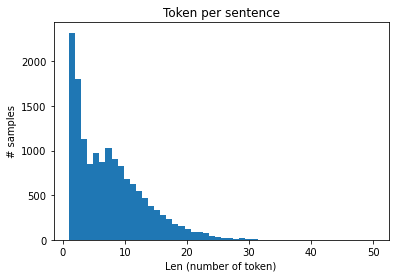

In [9]:
sentences[0]

In [ ]:
from matplotlib import pyplot as plt
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [39]:
LSTM_CRF_Tagger_ScienceExamCER(
    train_path='../../data/ScienceExamCER/train_spacy.txt',
    valid_path='../../data/ScienceExamCER/valid_spacy.txt',
    model_name='science_exam_cer',
    max_length=100,
    embedding_dim=20,
    epochs=50,
    batch_size=64,
    n_gpu=None
    ).reload_model_and_test(
    test_path='../../data/ScienceExamCER/test_spacy.txt'
    )

In [42]:
import joblib

ValueError: Unknown layer: CRF

In [ ]:
import time
import joblib
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
from keras.utils import multi_gpu_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

model = joblib.load('conll2000.joblib')